# Adapt origin and orientation across images

In [1]:
import sys
sys.path.append('..')
from faimed3d.basics import *
from fastai.basics import *

In this notebook, I will try to adapt spacing, origin and direction in three MRI sequences of the same examination. 

In [2]:
path = Path('/media/ScaleOut/prostata/data/dcm/A0001034961')

In [3]:
t1 = TensorDicom3D.create(path/'T1_map/DICOM')
t2 = TensorDicom3D.create(path/'T2/DICOM')
adc = TensorDicom3D.create(path/'ADC/DICOM')

I will use proprietary patient data from a research project, which cannot be uploaded to GitHub, so the code in this Notebook cannot be tested in the repositories CI. 

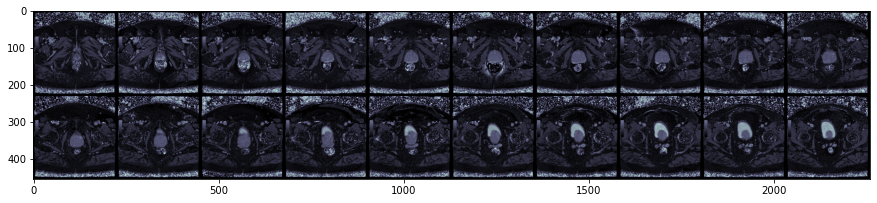

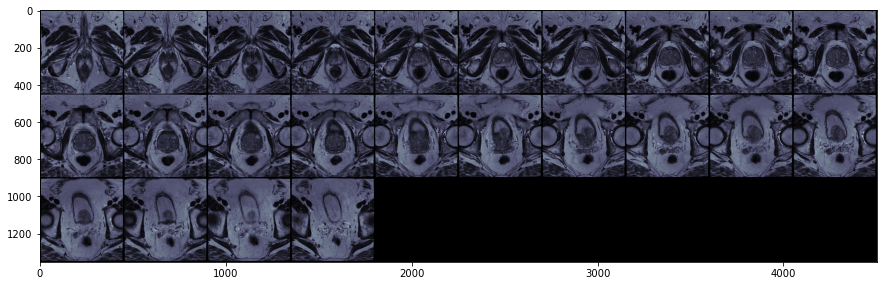

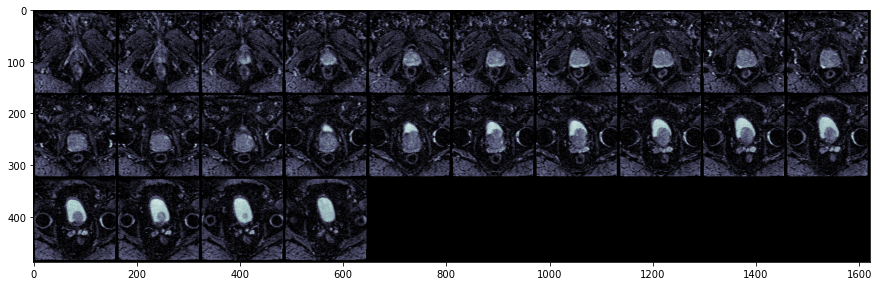

In [4]:
t1.show()
t2.show()
adc.show()

In this research project, I try to build a 4D CNN for prostate segmentation and cancer detection. I use four different sequences: axial T1 map, axial T2w, axial DWI and ADC. As ADC is derived from DWI spacing, orientation and direction should be the same. Thus only one of the sequences is loaded. The images are not preprocessed. 
ADC usually has a very low spatial resolution while T2w images can have a very high reolution. 

In [5]:
t1.size(), t2.size(), adc.size()

((20, 224, 224), (24, 448, 448), (24, 160, 160))

SimpleITK and PyTorch follow different conventions. While PyTorch refers to axis in a 3d Volume as Depth x Height x Width, SimpleITK refers to the axis as  Width x Height x Depth ([see here](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/03_Image_Details.html)).

## Origin
In SimpleITK, the origin of an image is not at the corner of the image. Instead, the image itself is inside a coordiante system. `get_origin` returns the coordinates of the lower lefthand pixel of the image in that coordiante system. 

In [6]:
t1.get_origin(), t2.get_origin(), adc.get_origin()

((-120.22447616082, -121.18354415962, -56.098028906373),
 (-69.479667359239, -70.683543205702, -59.446838620742),
 (-79.465965564272, -80.683546066774, -59.970198324618))

Looking at the above images, the field of view in T1 is much larger than for T2 and ADC (the trochanter major is seen on the t1 images but not on t2 and adc). Given the negative coordinates of the origins, the origin of the grid seems to be in the middle of the image (probably somewhere in the prostate).  
It is important to note, that the values given are mm, not pixels.

## Direction
Direction gives the direction cosine matrix for the pixel. 

In [7]:
t1.get_direction(), t2.get_direction(), adc.get_direction()

((0.9986295347979955,
  -4.890000000000001e-12,
  -0.052335955414409774,
  4.896696429748288e-12,
  1.0,
  -2.7366106817691636e-16,
  0.052335955414409774,
  -2.560000000000001e-13,
  0.9986295347979955),
 (0.9986295347979955,
  -4.890000000000001e-12,
  -0.052335955414409774,
  4.896696429748288e-12,
  1.0,
  -2.7366106817691636e-16,
  0.052335955414409774,
  -2.560000000000001e-13,
  0.9986295347979955),
 (0.9986295347979955,
  -4.890000000000001e-12,
  -0.052335955414409774,
  4.896696429748288e-12,
  1.0,
  -2.7366106817691636e-16,
  0.052335955414409774,
  -2.560000000000001e-13,
  0.9986295347979955))

Seems like in this case, we are lucky and the direction remains the same across all sequences. Meaning the technical assistant did not use a different angulation for the sequences. This will not always be the case.

## Spacing
Spacing gives the distance between to centers in a pixel

In [8]:
t1.get_spacing(), t2.get_spacing(), adc.get_spacing()

((1.2544642686844, 1.2544642686844, 3.0000000581780486),
 (0.40178570151329, 0.40178570151329, 2.9999999820249506),
 (1.25, 1.25, 2.9999999820249554))

When processing multiple 3D images, we want the Spacing, orientation and direction of all pixles to be the same (ot as similar as possible). 
Smaller spacing, means higher resolution of the image (larger image), larger spacing means smaller resolution.  
The best approach would probably be to downsacle the large images to fit the small images. 

## Unify the Origin
The goal is to align all images, so that the point of origin overlapps. 
To help with visualization, first a crude function, to highlight a certain point in a tensor is defined. 

In [9]:
@patch
def draw_point(x:TensorDicom3D, d:int,h:int,w:int):
    t = x.clone() # avoid overwriting the pixel values of source tensor
    sz_l = x.shape[1] // 20
    sz_w = x.shape[1] // 60
    
    t[d,h-sz_l:h+sz_l,w-sz_w:w+sz_w] = t.max()
    t[d,h-sz_w:h+sz_w,w-sz_l:w+sz_l] = t.max()
    return t

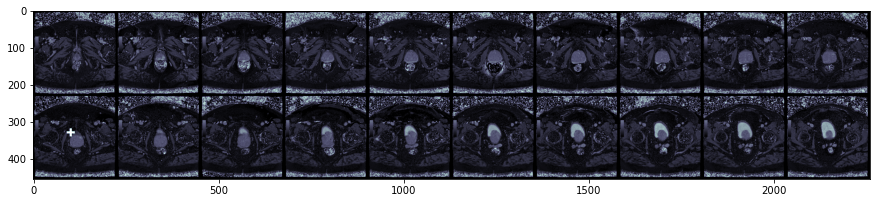

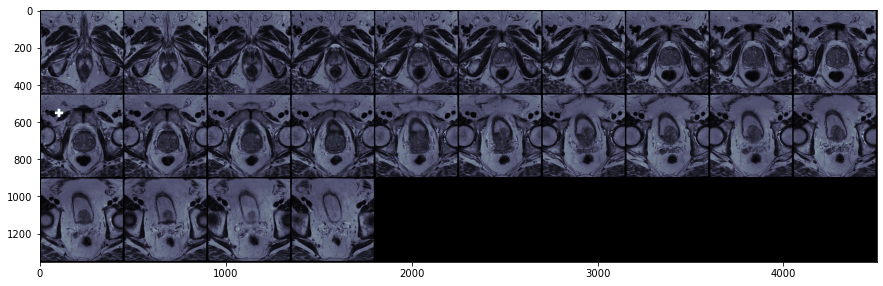

In [10]:
t1.draw_point(10, 100, 100).show()
t2.draw_point(10, 100, 100).show()

As image spacing and origin do not match in the above images, the point is not placed at the same position inside the patient. 

### Plot the origin
In SimpleITK the, lower left pixel of a 2D array has the coordinates 0,0. This differs from PyTorch, where 0,0 are the coordinates of the left upper pixel. 
`get_origin` returns the physical ids of the left lower pixel/voxel in the image. One could also interpret this as walking directions. Assuming `get_origin` returns `(-10, 11, 20)` this means one has to walk -10 mm up the width dimension, 11 mm down the width height and 20 mm up the depth dimension. If the ID of the origin is unknown and only the ID of the lower left pixel is know, the walking directions can just be reverted. 
However, in PyTorch one would start at the uper left pixel, so to reach the lower left pixel one first would have to walk down the whole length of the height dimension (H) to then again walk up 11 mm (which is equal to walk down H - 11 mm).  
To implement this in code, the physical dimension has to be converted to px by dividing the values by the pixel spacing. 

In [57]:
left_lwr = tuple(map(operator.truediv, t1.get_origin(), t1.get_spacing()))
left_lwr

(-95.83730614097406, -96.6018301076916, -18.69934260616058)

`left_lwr` now gives the walking directions from the origin to the left lower pixel in px. Inverting `left_lwr` will give the walking instructions to the `origin`

In [58]:
origin = tuple(map(operator.mul, left_lwr, (-1,-1,-1)))
origin

(95.83730614097406, 96.6018301076916, 18.69934260616058)

Now the subtracting the height-value from the image heigt, will yield the walking instructions from the left upper pixel. Finally floats are cast to integers, to enable indexing. 

In [59]:
d,h,w = origin
h = t1.shape[1]-h
origin = int(round(w)),int(round(h)),int(round(d))

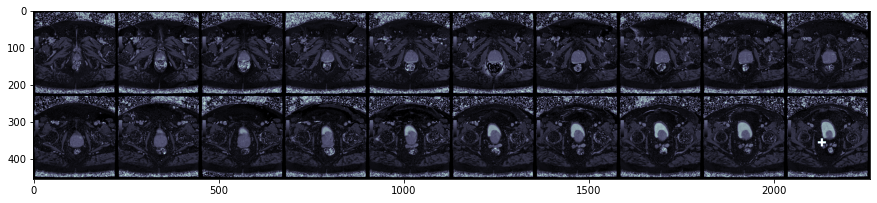

In [60]:
t1.draw_point(*origin).show()

Summarizing the above steps will give the follwing function. 

In [61]:
@patch
def get_origin_px_id(x:TensorDicom3D): 
    D,H,W = x.size()
    w,h,d = tuple(map(lambda a,b: int(round(a/b))*-1, x.get_origin(), x.get_spacing()))
    return d,H-h,w

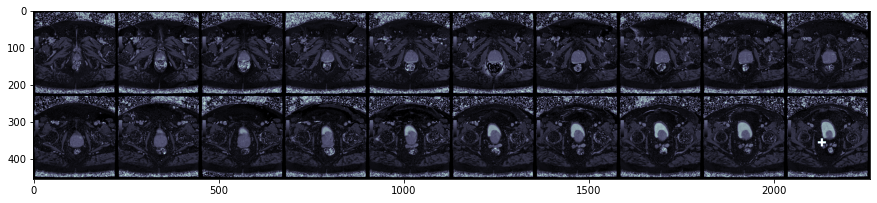

In [62]:
t1.draw_point(*t1.get_origin_px_id()).show()

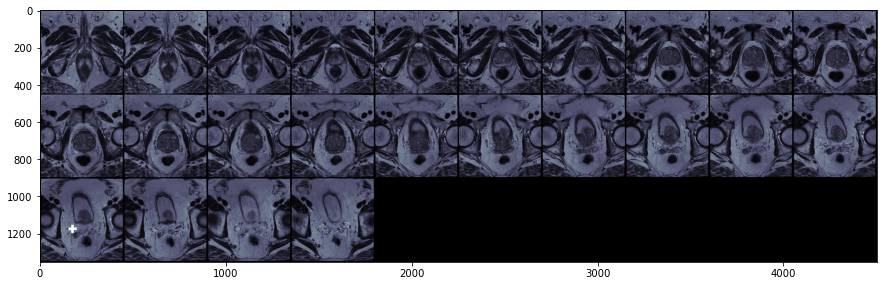

In [63]:
t2.draw_point(*t2.get_origin_px_id()).show()

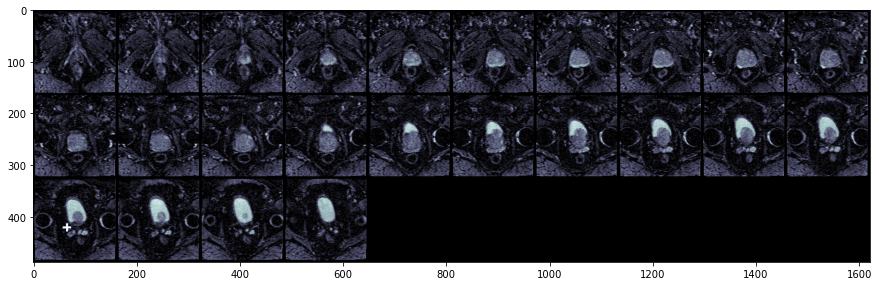

In [64]:
adc.draw_point(*adc.get_origin_px_id()).show()

Visually, it seems that the points are in the same anatomically region across all images. There might be small differences because of casting the pixel-ID to int, but those are probably not as important

### Get px ID of any point 

For a more general approach, it would be usefull to give any coordinate from the real world and recieve the ID of the pixel on that coordinate.
To get the px id of a physical point, first the origin is needed. 
The physical point is translated to px using the spacing and will now give the walking instructions to reach it, if starting from the origin. So walking to the origin and then to the point is the same as addint both paths together. 

In [176]:
@patch
def get_px_of_physical_point(x:TensorDicom3D, point:tuple): 
    d,h,w = x.get_origin_px_id()
    ph,pw,pd = tuple(map(lambda a,b: int(round(a/b)), point, x.get_spacing()))
    D,H,W = x.size() # h+ph needs to be subtracted from H as SimpleITK takes the lwr_left corner as 0,0,0
    return d+pd,h-ph,w+pw

## Get the physical ID of any point
Again, the origin is the staring point. The distance between the pixel and the origin will be the coordiante on the physical coordinate system.  The distance (`px_dist`) is calculated by subtracting the two points. Also the h-distance has to be inverted (since the lower left pixel in SimpleITK corresponds to the upper right pixel in PyTorch). The order of the `px_dist` is then inverted from D x H x W to W x H x D to match the SimpleITK convention. Finally the distances can be scaled using pixel spacing. 


In [204]:
@patch
def get_physical_point_of_px(x:TensorDicom3D, point:tuple): 
    px_dist= tuple(map(operator.sub, point, x.get_origin_px_id()))  
    px_dist = px_dist[::-1]
    pw, ph, pd = tuple(map(operator.mul, px_dist, x.get_spacing()))
    return ph*-1, pw, pd

Testing the functions

In [208]:
adc_orig = t1.get_px_of_physical_point(adc.get_origin())
adc_orig # negativer value mean, the dimension of this pixel is not within the FOV of the t1 image

(-1, 190, 32)

In [209]:
t1.get_physical_point_of_px(adc_orig), adc.get_origin()

((-79.0312489271172, -80.2857131958016, -60.000001163560974),
 (-79.465965564272, -80.683546066774, -59.970198324618))

In [210]:
adc_orig = t1.get_px_of_physical_point((-99.68303406238681, -21.42856979370241, -30.00000110538292))
adc_orig

(9, 206, 79)

In [211]:
t1.get_physical_point_of_px(adc_orig), (-99.68303406238681, -21.42856979370241, -30.00000110538292)

((-99.10267722606761, -21.325892567634803, -30.000000581780487),
 (-99.68303406238681, -21.42856979370241, -30.00000110538292))